In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score

import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

import matplotlib.pyplot as plt
%matplotlib inline

### Data Reader

In [2]:

with open('./DataNer.txt', 'r') as fr:
    res = []
    sent_num = 0
    doc_num = 0
    last = '=='
    for line in fr.readlines():
        line = line.strip()
        if line=='-DOCSTART- -X- O O':
            doc_num += 1
        if line=='' or line=='-DOCSTART- -X- O O':
            if last=='' or last=='-DOCSTART- -X- O O':
                pass
            else:
                sent_num+=1
            last = line
            continue
        last = line
        res.append([doc_num, sent_num]+line.split())
    print('doc num is {}, sentence num is {}'.format(doc_num, sent_num))

doc num is 960, sentence num is 14349


In [3]:
data_df = pd.DataFrame(res, columns=['doc_num', 'sent_num', 'word', 'pos', 'chunking_tag', 'tag'])

In [4]:
data_df.head()

,doc_num,sent_num,word,pos,chunking_tag,tag
0,1,1,He,PRP,I-NP,O
1,1,1,said,VBD,I-VP,O
2,1,1,further,JJ,I-NP,O
3,1,1,scientific,JJ,I-NP,O
4,1,1,study,NN,I-NP,O


In [5]:
data_df.shape, data_df.word.unique().shape

((207270, 6), (23825,))

In [6]:
data_df.groupby('tag').size().reset_index(name='cnt')

,tag,cnt
0,B-LOC,11
1,B-MISC,37
2,B-ORG,24
3,I-LOC,8454
4,I-MISC,4642
5,I-ORG,10214
6,I-PER,11394
7,O,172494


In [7]:
data_df.groupby('pos').size().reset_index(name='cnt')

,pos,cnt
0,"""",2225
1,$,430
2,'',37
3,(,2973
4,),2974
5,",",7426
6,.,7501
7,:,2456
8,CC,3713
9,CD,20218


In [8]:
data_df.groupby('chunking_tag').size().reset_index(name='cnt')

,chunking_tag,cnt
0,B-ADJP,2
1,B-ADVP,22
2,B-NP,3841
3,B-PP,258
4,B-SBAR,8
5,B-VP,166
6,I-ADJP,1395
7,I-ADVP,2804
8,I-CONJP,73
9,I-INTJ,61


In [9]:
data_df[['pos', 'chunking_tag']].drop_duplicates().shape

(200, 2)

From data exploration, we can see that:
    - There are 960 docs with 1439 sentences
    - There are 207270 rows, 6 columns and 23825 unique words
    - By grouping the data by tag, we can see that there are 8 unique values for label and 'O' has the most amount
    - By grouping the data by pos, we can see that there are 45 unique values for label and 'NNP' has the most amount
    - By grouping the data by chunking_data, we can see that there are 17 unique values for label and 'I-NP' has the most amount

### DataProcess

Using One-Hot Encoding to process data. Then split the data into train and test datasets

In [10]:
idx2tag = data_df['tag'].unique()
tag2idx = {v:k for k, v in enumerate(idx2tag)}
# data_df['label'] = data_df['tag'].map(tag2idx)
# One-hot Encode
X_ml = pd.get_dummies(data_df[['word', 'pos', 'chunking_tag']])
X_train, X_test, y_train, y_test = train_test_split(X_ml.values, data_df['tag'].values, test_size = 0.3, random_state=0)

### Model Fuc

Because of the large data size after One-Hot Encoding, I would create funtions for incremental training. Here I use 10 folds to process the data for each model that I will be implementing in the following report.

In [11]:
def train_model(model, X_train, y_train, flods=10):
    n = len(X_train)
    gap = n//flods
    print('training sample num is {}'.format(n))
    for i in range(1, flods):
        print('flods num is {}'.format(i))
        model.partial_fit(X_train[gap*(i-1):gap*i], y_train[gap*(i-1):gap*i], idx2tag)
    model.partial_fit(X_train[gap*i:], y_train[gap*i:], idx2tag)
    return model

def partial_pred(model, X_test, flods=10):
    n = len(X_test)
    gap = n//flods
    print('test sample num is {}'.format(n))
    y_pred = np.array([])
    for i in range(1, flods):
        print('flods num is {}'.format(i))
        p = model.predict(X_test[gap*(i-1):gap*i])
        y_pred = np.append(y_pred, p)
    p = model.predict(X_test[gap*i:])
    y_pred = np.append(y_pred, p)
    return y_pred

### SGD Linear Classifier

In [12]:
model = SGDClassifier(random_state=0)
model = train_model(model, X_train, y_train, flods=10)

training sample num is 145089
flods num is 1
flods num is 2
flods num is 3
flods num is 4
flods num is 5
flods num is 6
flods num is 7
flods num is 8
flods num is 9


In [13]:
y_pred= partial_pred(model,X_test)

test sample num is 62181
flods num is 1
flods num is 2
flods num is 3
flods num is 4
flods num is 5
flods num is 6
flods num is 7
flods num is 8
flods num is 9


In [14]:
result = f1_score(y_test, y_pred, average='weighted', labels=idx2tag)
print('the test sample num is :{}'.format(len(y_test)))
print('f1 score is :{}'.format(result))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


the test sample num is :62181
f1 score is :0.9189757278359705


In [15]:
result = classification_report(y_pred=y_pred, y_true=y_test, labels=idx2tag)
print(result)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           O       0.98      0.99      0.98     51703
       I-ORG       0.90      0.48      0.63      3078
       I-PER       0.97      0.42      0.58      3498
      I-MISC       0.78      0.59      0.67      1381
       I-LOC       0.39      0.88      0.54      2497
       B-LOC       0.00      0.00      0.00         5
      B-MISC       0.00      0.00      0.00        12
       B-ORG       0.00      0.00      0.00         7

    accuracy                           0.92     62181
   macro avg       0.50      0.42      0.43     62181
weighted avg       0.95      0.92      0.92     62181



I applied SGD Linear Classifier with 145089 train data and 62181 test data. The f1 score we got is 0.919, which is a decent number. But we need to compare it with following models in order to find the best one.

###  Multinomial Naive Bayes Model Classifier

In [16]:
model = MultinomialNB(alpha=0.01)
model = train_model(model, X_train, y_train, flods=10)
model

training sample num is 145089
flods num is 1
flods num is 2
flods num is 3
flods num is 4
flods num is 5
flods num is 6
flods num is 7
flods num is 8
flods num is 9


MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)

In [17]:
y_pred= partial_pred(model,X_test)

test sample num is 62181
flods num is 1
flods num is 2
flods num is 3
flods num is 4
flods num is 5
flods num is 6
flods num is 7
flods num is 8
flods num is 9


In [18]:
result = f1_score(y_test, y_pred, average='weighted', labels=idx2tag)
print('the test sample num is :{}'.format(len(y_test)))
print('f1 score is :{}'.format(result))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


the test sample num is :62181
f1 score is :0.9572338661892663


In [19]:
result = classification_report(y_pred=y_pred, y_true=y_test, labels=idx2tag)
print(result)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           O       0.99      0.98      0.99     51703
       I-ORG       0.83      0.71      0.76      3078
       I-PER       0.79      0.96      0.87      3498
      I-MISC       0.66      0.79      0.72      1381
       I-LOC       0.85      0.82      0.84      2497
       B-LOC       0.00      0.00      0.00         5
      B-MISC       0.00      0.00      0.00        12
       B-ORG       0.88      1.00      0.93         7

    accuracy                           0.96     62181
   macro avg       0.62      0.66      0.64     62181
weighted avg       0.96      0.96      0.96     62181



I applied the Multinomial Naive Bayes Model Classifier with alpha = 0.01 and the f1 score is 0.957, which is higher than that of SGD Linear Classifier.

### Perceptron Classifier.

In [20]:
model = Perceptron( n_jobs=-1, max_iter=8)
model = train_model(model, X_train, y_train, flods=10)
model

training sample num is 145089
flods num is 1
flods num is 2
flods num is 3
flods num is 4
flods num is 5
flods num is 6
flods num is 7
flods num is 8
flods num is 9


Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=8, n_iter_no_change=5, n_jobs=-1,
           penalty=None, random_state=0, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False)

In [21]:
y_pred= partial_pred(model,X_test)

test sample num is 62181
flods num is 1
flods num is 2
flods num is 3
flods num is 4
flods num is 5
flods num is 6
flods num is 7
flods num is 8
flods num is 9


In [22]:
result = f1_score(y_test, y_pred, average='weighted', labels=idx2tag)
print('the test sample num is :{}'.format(len(y_test)))
print('f1 score is :{}'.format(result))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


the test sample num is :62181
f1 score is :0.9421607695711566


In [23]:
result = classification_report(y_pred=y_pred, y_true=y_test, labels=idx2tag)
print(result)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           O       0.99      0.99      0.99     51703
       I-ORG       0.88      0.52      0.65      3078
       I-PER       0.96      0.68      0.80      3498
      I-MISC       0.81      0.74      0.77      1381
       I-LOC       0.49      0.92      0.64      2497
       B-LOC       1.00      0.60      0.75         5
      B-MISC       0.00      0.00      0.00        12
       B-ORG       0.88      1.00      0.93         7

    accuracy                           0.94     62181
   macro avg       0.75      0.68      0.69     62181
weighted avg       0.96      0.94      0.94     62181



I applied the Perceptron Classifier with n_jobs=-1, max_iter=8, and alpha = 0.0001. The f1 score is 0.942, still not as high as the Multinomial Naive Bayes Model Classifier.

### Conditional Random Fields (CRF)

In [24]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]
    
    features = {
        'bias': 1.0, 
        'word.lower()': word.lower(), 
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True
    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True

    return features

def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]


In [25]:

agg_func = lambda s: [(w, p, t) for w, p, t in zip(s['word'].values.tolist(), 
                                                   s['pos'].values.tolist(), 
                                                   s['tag'].values.tolist())]
grouped = data_df.groupby('sent_num').apply(agg_func)
sentences = [s for s in grouped]

X = [sent2features(s) for s in sentences]
y = [sent2labels(s) for s in sentences]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [26]:
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(X_train, y_train)
y_pred = crf.predict(X_test)

In [27]:
result = metrics.flat_f1_score(y_test, y_pred, average='weighted', labels=idx2tag)
print('f1 score is :{}'.format(result))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


f1 score is :0.9796403640122624


In [28]:
result = metrics.flat_classification_report(y_test, y_pred, labels = idx2tag)
print(result)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


              precision    recall  f1-score   support

           O       0.99      1.00      0.99     52496
       I-ORG       0.89      0.86      0.87      2935
       I-PER       0.92      0.94      0.93      3404
      I-MISC       0.92      0.83      0.87      1380
       I-LOC       0.92      0.92      0.92      2480
       B-LOC       1.00      0.50      0.67         4
      B-MISC       0.00      0.00      0.00         6
       B-ORG       0.00      0.00      0.00         0

   micro avg       0.98      0.98      0.98     62705
   macro avg       0.71      0.63      0.66     62705
weighted avg       0.98      0.98      0.98     62705



To implement the CRF model, I used word2features and grouped by sent_num. The f1 score is 0.980, which is very good.

### Bidirectional LSTM-CRF model

In [39]:
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Input, Sequential
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers.crf import CRF
from keras.optimizers import Adam
import keras

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch': [], 'epoch': []}
        self.accuracy = {'batch': [], 'epoch': []}
        self.val_loss = {'batch': [], 'epoch': []}
        self.val_acc = {'batch': [], 'epoch': []}

    def on_batch_end(self, batch, logs={}):
        print(logs.keys())
        print(logs.get('crf_viterbi_accuracy'))
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('crf_viterbi_accuracy'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_crf_viterbi_accuracy'))

    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('crf_viterbi_accuracy'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_crf_viterbi_accuracy'))

    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        # acc
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train crf_viterb_acc')
        # loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val crf_viterb_acc')
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('crf_viterb_acc-loss')
        plt.legend(loc="upper right")
        plt.show()
logs_loss = LossHistory()

In [40]:
maxlen = max([len(s) for s in sentences])

idx2word = data_df['word'].unique().tolist()
idx2word.append("ENDPAD")
n_words = len(idx2word)
word2idx = {w: i for i, w in enumerate(idx2word)}

idx2tag = data_df['tag'].unique().tolist()
idx2tag.append('TAGPAD')
n_tags = len(idx2tag)
tag2idx = {t: i for i, t in enumerate(idx2tag)}

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=maxlen, sequences=X, padding="post",value=n_words - 1)

y = [[tag2idx[w[-1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=maxlen, sequences=y, padding="post", value=n_tags-1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


In [41]:

EMBEDDING_OUT_DIM = 200
model = Sequential()
model.add(Embedding(input_dim=n_words, output_dim=EMBEDDING_OUT_DIM, input_length=maxlen))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(units=128, return_sequences=True, recurrent_dropout=0.3)))
model.add(TimeDistributed(Dense(n_tags)))
crf_layer = CRF(n_tags, sparse_target=True)
model.add(crf_layer)
model.compile(optimizer='adam', loss=crf_layer.loss_function, metrics=[crf_layer.accuracy])
history = model.fit(X_train, y_train.reshape(y_train.shape[0], y_train.shape[1], 1), batch_size=128, 
                    validation_data=(X_test, y_test.reshape(y_test.shape[0], y_test.shape[1], 1)),
                    epochs=6, verbose=1, callbacks=[logs_loss])


C:\ProgramData\Anaconda3\lib\site-packages\keras_contrib\layers\crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
C:\ProgramData\Anaconda3\lib\site-packages\keras_contrib\layers\crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 10044 samples, validate on 4305 samples
Epoch 1/6
  128/10044 [..............................] - ETA: 12:41 - loss: 1.6979 - crf_viterbi_accuracy: 0.8569dict_keys(['batch', 'size', 'loss', 'crf_viterbi_accuracy'])
0.8568861
  256/10044 [..............................] - ETA: 10:34 - loss: 1.6104 - crf_viterbi_accuracy: 0.8711dict_keys(['batch', 'size', 'loss', 'crf_viterbi_accuracy'])
0.8710592
  384/10044 [>.............................] - ETA: 9:43 - loss: 1.5337 - crf_viterbi_accuracy: 0.8721 dict_keys(['batch', 'size', 'loss', 'crf_viterbi_accuracy'])
0.87211925
  512/10044 [>.............................] - ETA: 9:20 - loss: 1.4564 - crf_viterbi_accuracy: 0.8676dict_keys(['batch', 'size', 'loss', 'crf_viterbi_accuracy'])
0.8676196
  640/10044 [>.............................] - ETA: 9:02 - loss: 1.3625 - crf_viterbi_accuracy: 0.8678dict_keys(['batch', 'size', 'loss', 'crf_viterbi_accuracy'])
0.86776817
  768/10044 [=>............................] - ETA: 8:49 - loss: 1.2580

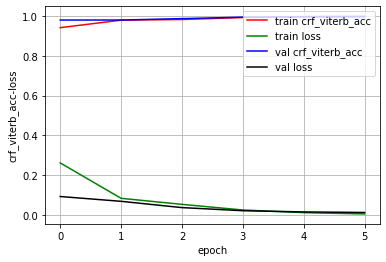

In [43]:
logs_loss.loss_plot('epoch')

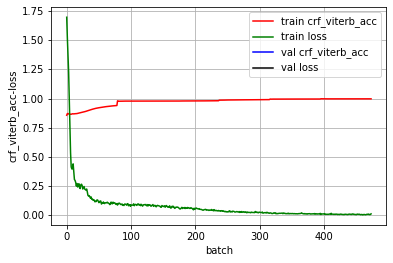

In [44]:
logs_loss.loss_plot('batch')

In [45]:
def pred_idx2tag(y_true, y_pred):
    y_, p_ = [], []
    y_pred = np.argmax(y_pred, axis=-1)
    for y_item, p_item in zip(y_true, y_pred):
        for y,p in zip(y_item, p_item):
            if idx2tag[y]=='TAGPAD':
                break
            else:
                y_.append(idx2tag[y])
                p_.append(idx2tag[p])
    return np.array(y_), np.array(p_)

y_pred = model.predict(X_test)   
ytest, ptest = pred_idx2tag(y_test, y_pred)

In [46]:
ytest.shape, ptest.shape

((61560,), (61560,))

In [47]:
result = f1_score(ytest, ptest, average='weighted', labels=idx2tag)
print('f1 score is :{}'.format(result))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


f1 score is :0.962421512628273


In [48]:
result = classification_report(ytest, ptest, labels=idx2tag)
print(result)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


              precision    recall  f1-score   support

           O       0.98      0.99      0.98     51215
       I-ORG       0.81      0.81      0.81      3069
       I-PER       0.96      0.82      0.89      3393
      I-MISC       0.89      0.73      0.80      1370
       I-LOC       0.90      0.87      0.88      2495
       B-LOC       0.00      0.00      0.00         3
      B-MISC       0.00      0.00      0.00         7
       B-ORG       0.00      0.00      0.00         8
      TAGPAD       0.00      0.00      0.00         0

    accuracy                           0.96     61560
   macro avg       0.50      0.47      0.49     61560
weighted avg       0.96      0.96      0.96     61560



To implement the Bidirectional LSTM-CRF model, I used keras to apply. The f1 score was 0.962, still slightly lower than the CRF model.

Conclusion:
I will choose the Conditional Random Fields (CRF) model. It has the best performance since it has the largest F1 score of 0.9796403640122624.